In [239]:
## Analysis of 3d Truss structures
import sys, os
import numpy as np

import cvxpy as cp
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
  
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    cwdGoogle = '/content/drive/MyDrive/AIM/projects/2022_truss_optimization/pythonTrussFEM/'
    sys.path.append(cwdGoogle)
else:
    cwdGoogle = ''
  
from trussFEM import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 3D Truss analysis
 assuming linear elasticity and truss elements

In [240]:
# Folder containing all your models
inputFolder='input/'
# Folder containing all your models
outputFolder='output/'
# Sub folder containing the particular model for analysis
inputModel='11158_bar/'
# The unit which to do the simulation and optimization in, note the input files are always in m
inputUnit='mm'

# Read data from file and put all in matlab tables
cwd=cwdGoogle+inputFolder+inputModel

# Read data from file and put all in matlab tables
owd=cwdGoogle+outputFolder+inputModel

[inputData, num] = importData(cwd, inputUnit)

# Initialization of material and geometrical properties
# Initialize # of DOF, calculate elem. and glb. DOF, and material yield strength, stiffness, and cross sectional area
# Construct a struct containing all of this information per element
[glb, elem, num] = initializeStruct(inputData, num)

In [241]:
# assemble adjacency matrix
[glb['C'], glb['A'], elem['L']] = assembleA(num, inputData['nodes'], elem['n0'],elem['n1'])

# construct element wise stiffness
elem['B'] = elem['E']*elem['A']/elem['L']


# assemble material stiffness matrix
glb['Km']  = assembleKm(glb['A'],elem['B'], num)

# solve the linear system
[glb,elem,status] = SolverLE(glb, elem, num)

glb['Volume']=sum(elem['A']*elem['L'])

# Equilibrium, compatibility and stiffness check
print('Equilibrium (Af+F)^2 MSE='      + str(status['equilibrium']))
print('Compatibility (Bf+A^Tu)^2 MSE=' + str(status['compatibility']))
print('Stiffness mean (Ku-F)^2 MSE='   + str(status['stiffness']))


Equilibrium (Af+F)^2 MSE=4.246308636049858e-20
Compatibility (Bf+A^Tu)^2 MSE=3.994246963860721e-33
Stiffness mean (Ku-F)^2 MSE=4.5006776298901886e-20


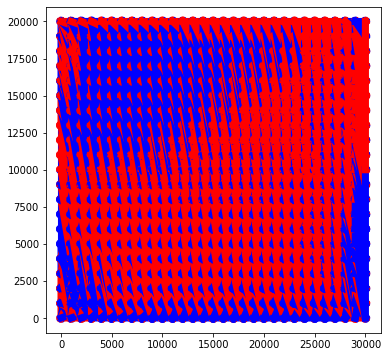

In [242]:
# tog - plot ON/OFF, deform shape , modal shape, modal #, scale of def, color 1=stress, 2=mat
plotting = dict()
plotting['IO']=True # true - plot, false - do not plot
plotting['deformed']= 1 # 0 - original, 1 - deformed, 2 - both
plotting['view']= '2d' # 0 - original, 1 - deformed, 2 - both
plotting['xsec']= 'a' # 0 - original, 1 - deformed, 2 - both
plotting['sf'] = dict()
plotting['sf']['a']= 0.05
plotting['sf']['f']= 10

if plotting['IO']==True:
    plotStructFun(glb, elem, inputData['nodes'], inputUnit, elem['A'], elem['f'], plotting)

### Linear programming:
Minimize volume by optimizing with cross section, constrained by yield stress and minimum and maximum cross section area

In [243]:
[a_opt,f_opt, sol]=optTrussLP(glb, elem, num, 'cvx',  inputData['parameters']['yieldStress'], inputData['parameters']['minA'], inputData['parameters']['maxA'])

### Plot the optimized structure

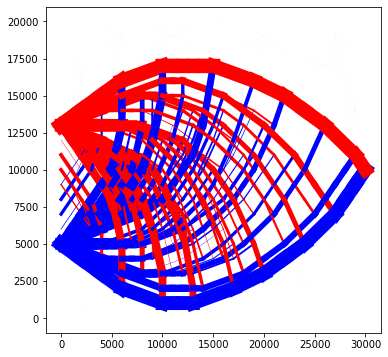

In [244]:
# tog - plot ON/OFF, deform shape , modal shape, modal #, scale of def, color 1=stress, 2=mat
plotting = dict()
plotting['IO']=True # true - plot, false - do not plot
plotting['deformed']= 1 # 0 - original, 1 - deformed, 2 - both
plotting['view']= '2d' # 0 - original, 1 - deformed, 2 - both
plotting['xsec']= 'a' # 0 - original, 1 - deformed, 2 - both
plotting['sf'] = dict()
plotting['sf']['a']= 1
plotting['sf']['f']= 10

if plotting['IO']==True:
    plotStructFun(glb, elem, inputData['nodes'], inputUnit, a_opt, f_opt, plotting)

### Post processing

In [273]:
# filter out all the bars with cross section that's less than x
[fGlb,fElem] = areaFilter(glb, inputData['nodes'], elem, a_opt, f_opt,2)

print("Number of bars remaining: " + str(len(fElem['n0'])))
# Folder containing all your models
outputFolder='output/'
# Read data from file and put all in matlab tables
owd=cwdGoogle+outputFolder+inputModel

writeOutput(owd, fGlb, fElem, inputUnit)

Number of bars remaining: 329


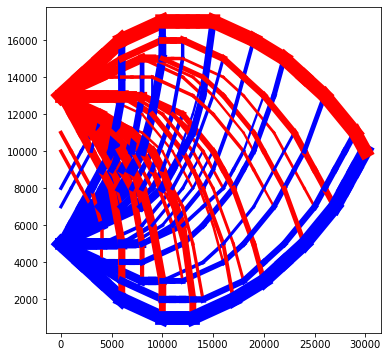

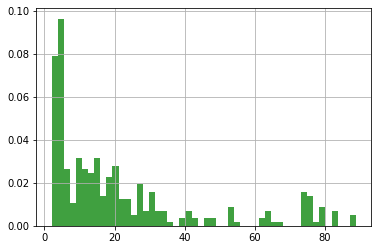

In [274]:
# tog - plot ON/OFF, deform shape , modal shape, modal #, scale of def, color 1=stress, 2=mat
plotting = dict()
plotting['IO']=True # true - plot, false - do not plot
plotting['deformed']= 1 # 0 - original, 1 - deformed, 2 - both
plotting['view']= '2d' # 0 - original, 1 - deformed, 2 - both
plotting['xsec']= 'a' # 0 - original, 1 - deformed, 2 - both
plotting['sf'] = dict()
plotting['sf']['a']= 1
plotting['sf']['f']= 10

if plotting['IO']==True:
    plotStructFun(fGlb, fElem, fGlb['nodes'], inputUnit, fElem['a'], fElem['f'], plotting)
    
    import numpy as np
    import matplotlib.pyplot as plt
    # the histogram of the data
    n, bins, patches = plt.hist(fElem['a'], 50, density=True, facecolor='g', alpha=0.75)

    plt.grid(True)
    plt.show()

### QP programming:
Minimize compliance + volume by optimizing with cross section, constrained by yield stress and minimum and maximum cross section area

In [ ]:
# Import packages.
import cvxpy as cp
import numpy as np
def optTrussQP(glb, elem, num, yieldStress, d_max, V_max):
    f_id  = np.ix_(glb['fDOF'])
    
    f_obj    = np.ones(num['m'])
    
    LE =  cp.sqrt(elem['L']/elem['E'])
    
    M  = np.eye(num['m'])
    d  = np.ones(num['m']) * d_max  
    
    # Define and solve the CVXPY problem.
    f = cp.Variable(num['m'])
    a = cp.Variable(num['m'],nonneg=True)
    s = cp.Variable(num['m'],nonneg=True)
    l = cp.Parameter(num['m'],pos=True)
    print("curvature of f:", f.curvature)
    print("curvature of a:", a.curvature)
    print("curvature of s:", s.curvature)
    print("curvature of s:", cp.multiply(a,s).curvature)

    print("curvature of s:", cp.multiply(LE,cp.square(f)).curvature)

    # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.

    a_bounds = [a[i]>=0 for i in range(num['m'])]
    s_bounds = [s[i]>=0 for i in range(num['m'])]
    q_constraints = [cp.multiply(LE,cp.square(f)) <= cp.multiply(a,s)]
    prob = cp.Problem(
                    cp.Minimize(
                    cp.sum(s)     # objective, minimizing compliance
                    ), 
                    q_constraints  
                      + a_bounds
                      + s_bounds
                      + [glb['A'][f_id] @ f == -glb['F'][f_id]]          # equilibrium constraint
                      + [M @ a <= d]                                 # individual max area constraint
                      #+ [elem['L'].T @ (w-y) <= V_max]                   # Total volume constraint
                      #+ [- np.eye(num['m'])*yieldStress @ (w-y) <= f]    # lower stress bound
                      #+ [ f <= np.eye(num['m'])*yieldStress @ (w-y)]    # upper stress bound
                     )
    prob.solve()
    
    a_opt = a.value
    f_opt = f.value
    return [a_opt,f_opt]

[a_opt,f_opt] = optTrussQP(glb, elem, num,   inputData['parameters']['yieldStress'], inputData['parameters']['maxA'], 0.0005*sum(inputData['parameters']['maxA']*elem['L']))


print(a_opt)

### SOCP programming:
Minimize compliance + volume by optimizing with cross section, constrained by yield stress and minimum and maximum cross section area

In [221]:
# Import packages.
import cvxpy as cp
import numpy as np

def optTrussSOCP(glb, elem, num, yieldStress, d_max, V_max):
    f_id  = np.ix_(glb['fDOF'])
    
    f_obj    = np.ones(num['m'])
    
    LE = np.sqrt(elem['L']/elem['E'])
    
    M  = np.eye(num['m'])
    d  = np.ones(num['m']) * d_max  
    # Define and solve the CVXPY problem.
    f = cp.Variable(num['m'])
    w = cp.Variable(num['m'])
    y = cp.Variable(num['m'])
    
    # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.

    soc_constraints = [cp.SOC(w[i],cp.hstack([LE[i] * f[i], y[i]])) for i in range(num['m'])]

    prob = cp.Problem(
                    cp.Minimize(
                    1/2*f_obj.T@(w+y)     # objective, minimizing compliance
                    #+1/2*elem['L'].T @ (w-y) # objective, minimizing  and volume (This doesn't work well, we need to tune the weight)
                    ), 
                    soc_constraints  
                      + [glb['A'][f_id] @ f == -glb['F'][f_id]]          # equilibrium constraint
                      + [M @ (w-y) <= d]                                 # individual max area constraint
                      + [elem['L'].T @ (w-y) <= V_max]                   # Total volume constraint
                      #+ [- np.eye(num['m'])*yieldStress @ (w-y) <= f]    # lower stress bound
                      #+ [ f <= np.eye(num['m'])*yieldStress @ (w-y)]    # upper stress bound
                     )
    prob.solve(solver='SCS')
    
    a_opt = w.value - y.value
    s_opt = w.value + y.value
    
    return [a_opt,f_opt]

[a_opt,f_opt] = optTrussSOCP(glb, elem, num,   inputData['parameters']['yieldStress'], inputData['parameters']['maxA'], 0.1*sum(inputData['parameters']['maxA']*elem['L']))


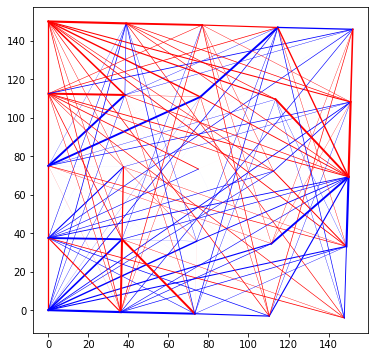

[ 1.57900084e+03  4.41786453e+03  2.71628157e+03  1.14055930e+02
  1.82336669e+02  4.93902175e+02  1.87570434e+03  1.98360642e+01
  1.25784978e+03  3.12120755e+02  4.67401269e+02  1.02830508e+03
  6.40129760e+02  1.57900084e+03  1.21136553e+03  3.46538985e+03
  1.16659855e+03  2.39146052e-01  2.34923776e+02  2.66966657e+02
  3.57239983e+02 -4.65613314e-01  4.58287056e+02  3.34109173e+02
 -1.33191440e-01  5.78766617e+02  6.77566273e+02  3.96113858e+02
  1.57900084e+03  1.09781683e+01 -2.91802328e-01  5.64085254e-01
  3.69510381e+03  5.11538023e+01 -1.48128750e-01  3.52169645e+03
  1.76480863e-01  1.06528250e+02  1.06522446e+02  2.34144933e-01
  4.17234492e+02  4.16583916e+02  1.57900084e+03  2.09411459e+02
  5.09992506e+02  1.95922518e+02  3.90404622e+03 -1.34135133e-01
  3.53902663e-02  6.53052699e+02  2.70254774e+02 -4.03329636e-01
  3.49344269e+02  4.68966033e+02  4.01245448e+02  6.76034123e+02
  5.82214462e+02  4.78391814e+02  1.96855762e+02  1.53973615e+02
  2.38199860e+03  4.41786

In [222]:
# tog - plot ON/OFF, deform shape , modal shape, modal #, scale of def, color 1=stress, 2=mat
plotting = dict()
plotting['IO']=True # true - plot, false - do not plot
plotting['deformed']= 1 # 0 - original, 1 - deformed, 2 - both
plotting['view']= '2d' # 0 - original, 1 - deformed, 2 - both
plotting['xsec']= 'a' # 0 - original, 1 - deformed, 2 - both
plotting['sf'] = dict()
plotting['sf']['a']= 0.02
plotting['sf']['f']= 10

if plotting['IO']==True:
    plotStructFun(glb, elem, inputData['nodes'], inputUnit, a_opt, f_opt, plotting)
    
print(a_opt)

In [ ]:
# Import packages.
import cvxpy as cp
import numpy as np
def optTrussSDP(glb, elem, num, yieldStress, d_max, V_max):
    f_id  = np.ix_(glb['fDOF'])
    
    f_obj    = np.ones(num['m'])
    
    LE = np.sqrt(elem['L']/elem['E'])
    
    M  = np.eye(num['m'])
    d  = np.ones(num['m']) * d_max  
    # Define and solve the CVXPY problem.
    a = cp.Variable(num['m'])
    theta = cp.Variable()
    
    f_id  = np.ix_(glb['fDOF'])

    aa = np.hstack((1,glb['F'][f_id]))

    A_free = glb['A'][f_id]
    
    i = 0
    
    print(np.shape(np.matmul(np.vstack(A_free[:,i]),np.hstack(A_free[:,i]))))
    
    KMat = []
    for i in range(num['m'])
    
    bb = [KMat+elem['E'][i]*a[i]/elem['L'][i]*np.matmul(A_free[:,i],A_free[:,i]).T for i in range(num['m'])]
    
    print(np.shape(bb))
    print(np.shape(glb['F']))
    #print(cp.hstack((glb['F'][f_id].T, bb))
    

optTrussSDP(glb, elem, num,   inputData['parameters']['yieldStress'], inputData['parameters']['maxA'], 0.0005*sum(inputData['parameters']['maxA']*elem['L']))





In [ ]:
# Alternative formulation - may be useful if we cannot use cvx

import cvxpy as cp
import numpy as np

def optTrussSOCP(glb, elem, num):
    f_id  = np.ix_(glb['fDOF'])
    
    # c is f
    c    = np.hstack((np.zeros(num['m']),np.ones(num['m']),np.ones(num['m'])))
    
    # Af = -F, This is F x = g in https://www.cvxpy.org/examples/basic/socp.html
    A_eq = np.hstack((glb['A'][f_id], np.zeros((len(glb['fDOF']),num['m'])), np.zeros((len(glb['fDOF']),num['m']))))

    b_eq = -glb['F'][f_id]
    
    # || L/E f^2 + y || < w
    
    # LE = A
    LE = np.hstack((np.diag(np.sqrt(elem['L']/elem['E'])), np.zeros((num['m'],num['m'])), np.zeros((num['m'],num['m']))))
    # y = b
    y  = np.hstack((np.eye(num['m'])*0., np.eye(num['m'])*0.,  np.eye(num['m'])))
    # w = c
    w  = np.hstack((np.eye(num['m'])*0., np.eye(num['m']),     np.eye(num['m'])*0.))
    
    M  = np.hstack((np.eye(num['m'])*0., np.eye(num['m']),    -1*np.eye(num['m'])))

    d  = np.ones(num['m'])    
    
    # Define and solve the CVXPY problem.
    x = cp.Variable(3*num['m'])
    
    soc_constraints = [cp.SOC(w[i] @ x, cp.hstack([LE[i] @ x, y[i]])) for i in range(num['m'])]
    
    prob = cp.Problem(cp.Minimize(c.T@x), soc_constraints + [A_eq @ x == b_eq] + [M @ x <= d])
    prob.solve()
    print("The optimal value is", prob.value)
    print("A solution x is")
    f_opt = x.value[0:num['m']]
    w_opt = x.value[num['m']:num['m']*2]
    y_opt = x.value[2*num['m']:]
    a_opt = w_opt - y_opt
    s_opt = w_opt + y_opt
    return 0

optTrussSOCP(glb, elem, num)